In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import os
from dask.diagnostics import ProgressBar
from wmt_inert_tracer.preprocessing import preprocessing
import cmocean.cm as cmo
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append('/home/Jan-erik.Tesdal/wmt-inert-tracer/scripts/tools')
from plot import hovmoeller, cartopy_map_so
from compute import get_xgcm_grid # ????

In [4]:
from wmt_inert_tracer.wmt import wmt
from wmt_inert_tracer.compute import lbin_define
import fastjmd95 as jmd95

In [5]:
from wmt_inert_tracer.compute import zonal_mean

In [6]:
outdir='/work/jet/data/interim/'

# Odiv-209, Odiv-207, Odiv-206, Odiv-200, Odiv-191, Odiv-184
rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/' 
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/' # Odiv-183, Odiv-170

subdir = 'CM4_piControl_c192_OM4p125_v7' # Odiv-209
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt3' # Odiv-207
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt2' # Odiv-206
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt1' # Odiv-200
#subdir = 'CM4_piControl_c192_OM4p125_v6' # Odiv-191
#subdir = 'CM4_piControl_c192_OM4p125_v5' # Odiv-184
#subdir = 'CM4_piControl_c192_OM4p125_v5_proto1' # Odiv-183
#subdir = 'CM4_piControl_c192_OM4p25' # Odiv-170

platfrom = 'gfdl.ncrc4-intel18-prod-openmp'

In [7]:
#pp = 'ocean_annual_z'# Odiv-191, Odiv-170
pp = 'ocean_annual_z_d2'# Odiv-206, Odiv-200, Odiv-184, Odiv-183
full_path = os.path.join(rootdir,subdir,platfrom,'pp',pp)+'/ts/annual/10yr/'

In [8]:
var = 'agessc'
print('dmls -lah',full_path+pp+'.*.%s.nc'%var)
print('dmget',full_path+pp+'.*.%s.nc'%var,'&')

dmls -lah /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/ocean_annual_z_d2.*.agessc.nc
dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/ocean_annual_z_d2.*.agessc.nc &


In [15]:
vars_ds = xr.open_mfdataset(full_path+pp+'.*.%s.nc'%var,use_cftime=True, drop_variables=['average_DT','average_T1','average_T2'])

In [16]:
grid = xr.open_dataset(os.path.join(rootdir,subdir,platfrom,'pp',pp)+'/'+pp+'.static.nc')

In [17]:
pd.concat([vars_ds.xh.to_series().reset_index(drop=True), #vars_ds.xq.to_series().reset_index(drop=True),
           grid.xh.to_series().reset_index(drop=True), grid.xq.to_series().reset_index(drop=True)], axis=1)

,xh,xh,xq
0,-298.604803,-298.417040,-298.533319
1,-298.372071,-298.184466,-298.300755
2,-298.139319,-297.951872,-298.068172
3,-297.906548,-297.719259,-297.835568
4,-297.673757,-297.486626,-297.602945
...,...,...,...
1436,60.464470,60.652868,60.536629
1437,60.697121,60.885360,60.769112
1438,60.929793,61.117873,61.001614
1439,61.162485,61.350407,61.234138


In [18]:
pd.concat([vars_ds.yh.to_series().reset_index(drop=True), #vars_ds.yq.to_series().reset_index(drop=True),
           grid.yh.to_series().reset_index(drop=True), grid.yq.to_series().reset_index(drop=True)], axis=1)

,yh,yh,yq
0,-83.622544,-83.563460,-83.602858
1,-83.543748,-83.484560,-83.524027
2,-83.464814,-83.405527,-83.445060
3,-83.385749,-83.326368,-83.365963
4,-83.306560,-83.247089,-83.286743
...,...,...,...
1116,89.589108,89.671286,89.616501
1117,89.698679,89.780857,89.726072
1118,89.808250,89.890429,89.835643
1119,89.917822,90.000000,89.945214


In [19]:
grid = grid.assign_coords({'xh':vars_ds.xh,'yh':vars_ds.yh})#,'xq':vars_ds.xq,'yq':vars_ds.yq}) # Odiv-206, Odiv-200, Odiv-183
#grid = grid.isel(xq=slice(1,None),yq=slice(1,None)) # Odiv-200, Odiv-183, Odiv-170
#vars_ds = vars_ds.isel(xq=slice(1,None),yq=slice(1,None)) # Odiv-200, Odiv-191, Odiv-184, Odiv-183, Odiv-170

In [20]:
ds = preprocessing(vars_ds, grid, decode_times=False, verbose=False)

In [21]:
print(str(ds.time.values[0])[:10],'to',str(ds.time.values[-1])[:10])

0001-07-02 to 0090-07-02


In [22]:
yr_st,yr_ed = '0081','0090'

### Bottom age

In [23]:
ds['bottom_age'] = ds.agessc.chunk({'time':1}).ffill('lev').isel(lev=-1)

In [24]:
from compute import mean_bottom_age

In [25]:
# Mean bottom age in the deep Southern Ocean below 4000 m
with ProgressBar():
    ageb_so = mean_bottom_age(ds.sel(y=slice(None,-30)),'bottom_age',4000).load()

[########################################] | 100% Completed |  1min 24.1s


In [26]:
# Check for missing time points
ageb_so.isel(time=slice(0,-1))[ageb_so.time.dt.year.diff(dim='time',label='lower') > 1].time

<xarray.DataArray 'time' (time: 0)>
array([], dtype=object)
Coordinates:
  * time     (time) object 
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  NOLEAP
    bounds:         time_bnds

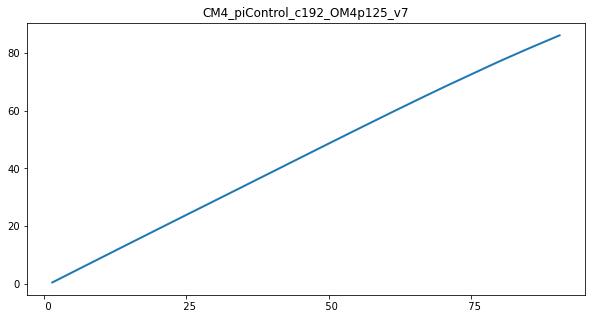

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ageb_so.time, ageb_so, lw=2, ls='-')
ax.set_title(subdir)
plt.show()

In [28]:
# Isolate Southern Ocean
#north = -65.8
#north = -58.0
north = -30.0

# Isolate Southern Ocean
ds_so = ds.drop_dims('nv').where(ds.lat<north,drop=True)
ds_so['time_bnds'] = ds.time_bnds

In [29]:
ds_so['age_norm_to_bottom_so'] = ds_so.agessc/ageb_so

In [30]:
with ProgressBar():
    ageb_norm_final = ds_so.isel(time=-1).ffill('lev').isel(lev=-1).age_norm_to_bottom_so.load()

[########################################] | 100% Completed | 10.2s


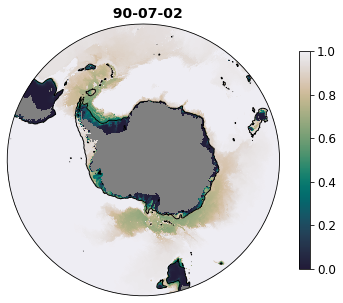

In [31]:
ds_so['ageb_norm_final'] = ageb_norm_final
fig, ax = cartopy_map_so(ds_so,'ageb_norm_final', lat=-45, fsize=[7,5],cmap=cmo.rain_r, vrange=[0,1], 
                         title=str(ds_so.isel(time=-1).time.dt.strftime('%Y-%m-%d').values))

In [32]:
ds_so = ds_so.sel(time=slice('0061',None))

In [33]:
with ProgressBar():
    ageb_norm = ds_so.ffill('lev').isel(lev=-1).age_norm_to_bottom_so.load()

[########################################] | 100% Completed | 28.7s


In [42]:
ageb_norm = xr.concat([xr.open_dataset(outdir+'CM4_piControl_c192_OM4p125_v7_so_0001to0060_southof300S_bottom_age_norm_so.nc').bottom_age_norm,
                       ageb_norm],dim='time')

In [43]:
#ageb_norm = ds_so.ffill('lev').isel(lev=-1).age_norm_to_bottom_so
ageb_norm.attrs = {'long_name': 'Bottom age normalized to the spatial mean bottom age of the deep Southern Ocean (south of 30 S and below 4000 m)'}
ds_out = ageb_norm.reset_coords(drop=True).to_dataset(name='bottom_age_norm')
ds_out['areacello'] = ds_so.areacello
ds_out['deptho'] = ds_so.deptho
ds_out['wet'] = ds_so.wet

In [45]:
var = 'bottom_age_norm_so'
fname = subdir+'_so_%sto%s_southof%sS_%s.nc'%(str(ageb_norm.time.dt.year[0].values).rjust(4, '0'),
                                              str(ageb_norm.time.dt.year[-1].values).rjust(4, '0'),
                                              str(abs(north)).replace('.',''), var)
print('Saving to file:', fname)
with ProgressBar():
    ds_out.reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_piControl_c192_OM4p125_v7_so_0001to0090_southof300S_bottom_age_norm_so.nc
[########################################] | 100% Completed |  0.1s


In [46]:
ageb_norm = xr.open_dataset(outdir+fname).bottom_age_norm

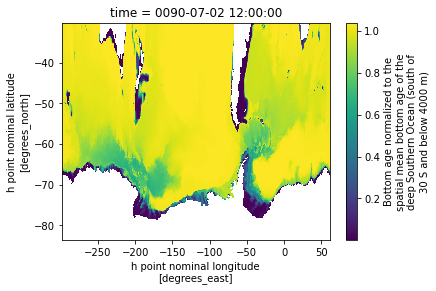

In [47]:
ageb_norm[-1].plot()

In [49]:
with ProgressBar():
    ageb = ds_so.ffill('lev').isel(lev=-1).agessc.load()

[########################################] | 100% Completed | 28.5s


In [50]:
ageb = xr.concat([xr.open_dataset(outdir+'CM4_piControl_c192_OM4p125_v7_so_0001to0060_southof300S_bottom_age.nc').bottom_age, ageb],dim='time')

In [51]:
#ageb = ds_so.ffill('lev').isel(lev=-1).agessc
ageb.attrs = {'long_name': 'Bottom age'}
ds_out = ageb.reset_coords(drop=True).to_dataset(name='bottom_age')
ds_out['areacello'] = ds_so.areacello
ds_out['deptho'] = ds_so.deptho
ds_out['wet'] = ds_so.wet

In [52]:
var = 'bottom_age'
fname = subdir+'_so_%sto%s_southof%sS_%s.nc'%(str(ageb.time.dt.year[0].values).rjust(4, '0'),
                                              str(ageb.time.dt.year[-1].values).rjust(4, '0'),
                                              str(abs(north)).replace('.',''), var)
print('Saving to file:', fname)
with ProgressBar():
    ds_out.reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_piControl_c192_OM4p125_v7_so_0001to0090_southof300S_bottom_age.nc
[########################################] | 100% Completed |  0.2s


In [53]:
ageb = xr.open_dataset(outdir+fname).bottom_age

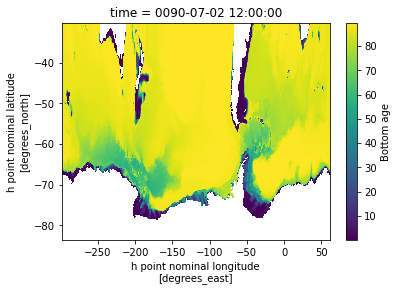

In [54]:
ageb[-1].plot()

### Ventilation

In [55]:
from plot import create_topomask
from wmt_inert_tracer.compute import zonal_mean

In [56]:
age_max = ds.agessc.max(dim=['lev','y','x'])
fage = 1 - zonal_mean(ds.agessc, ds)/np.ceil(age_max)

In [57]:
topomask = create_topomask(ds)

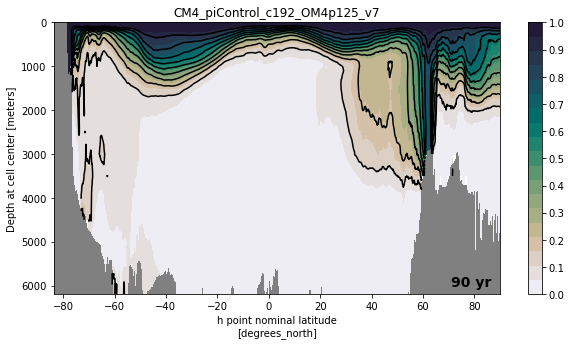

In [58]:
fig, ax = plt.subplots(figsize=(10,5))

p=fage.isel(time=-1).plot.contourf(ax=ax, x='y', y='lev', yincrease=False,levels=20, cmap=cmo.rain, vmin=0, vmax=1,
                                   add_colorbar=False)
fage.isel(time=-1).plot.contour(ax=ax, x='y', y='lev', yincrease=False, levels=np.arange(0,1.1,.1), 
                                colors='k', linewidths=1.5)
plt.colorbar(p,ticks=np.arange(0,1.1,.1))
ax.set_title(subdir)
topomask.plot(ax=ax, x='y', y='lev', yincrease=False, cmap='gray', shading='auto',
              add_colorbar=False, add_labels=False)
ax.text(0.98, 0.02, '%1.0f yr'%np.ceil(age_max.isel(time=-1)), ha='right', va='bottom', fontsize=14, fontweight='bold',transform=ax.transAxes)
ax.set_ylim((6200,0))
#plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [59]:
fage.attrs = {'long_name': 'Zonally averaged ventilated fraction'}
age_max.attrs = {'long_name': 'Maximum age', 'units': 'yr'}
ds_out = fage.reset_coords(drop=True).to_dataset(name='fage')
ds_out['age_max'] = age_max.reset_coords(drop=True)

In [61]:
var = 'fage'
fname = subdir+'_global_%sto%s_%s_zmean.nc'%(str(ds_out.time.dt.year[0].values).rjust(4, '0'),
                                             str(ds_out.time.dt.year[-1].values).rjust(4, '0'), var)
print('Saving to file:', fname)
#with ProgressBar():
#    ds_out.reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_piControl_c192_OM4p125_v7_global_0001to0090_fage_zmean.nc
